In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    rewrite_count: int
    decision: str

In [ ]:
import os
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

# # --- 데이터베이스 준비 (수동 생성한 Pinecone 인덱스 불러오기) ---

# # 1. .env 파일에서 Pinecone 인덱스 이름과 API 키를 가져옵니다.
# index_name = os.getenv("PINECONE_INDEX_NAME")
# if not os.getenv("PINECONE_API_KEY") or not index_name:
#     print("PINECONE_API_KEY 또는 PINECONE_INDEX_NAME이 설정되지 않았습니다.")

# # 2. 임베딩 함수를 초기화합니다.
# embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

# # 3. 임시 데이터를 준비합니다. (수동 생성한 빈 인덱스에 채워넣을 데이터)
# temp_documents = [
#     Document(page_content="[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.", metadata={"location": "강남", "day": "토"}),
#     Document(page_content="[홍대] 주말 오후 2시, 다 함께 보드게임 즐길 사람 모여라! 초심자 대환영.", metadata={"location": "홍대", "day": "주말"}),
#     Document(page_content="[온라인] 격주 수요일 저녁 9시, '사피엔스' 함께 읽고 토론하는 온라인 독서 모임.", metadata={"location": "온라인", "day": "수"}),
# ]

# # 4. PineconeVectorStore.from_documents를 사용해 데이터를 추가하고 VectorStore 객체를 생성합니다.
# # 이 함수는 인덱스가 비어있으면 데이터를 추가하고, 데이터가 있으면 그냥 연결만 합니다.
# print(f"수동으로 생성한 '{index_name}' 인덱스에 연결하고 데이터를 확인/추가합니다...")
# vector_store = PineconeVectorStore.from_documents(
#     documents=temp_documents,
#     embedding=embedding_function,
#     index_name=index_name
# )
# print("데이터 준비 완료!")


# 5. Retriever를 생성합니다.
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

print(f"수동으로 생성한 Pinecone 인덱스 '{index_name}'를 성공적으로 불러왔습니다.")

c:\Users\user\MOIT\MOIT_AGENT\MOIT_graph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\MOIT\MOIT_AGENT\MOIT_graph\Lib\site-packages\langchain_pinecone\__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_pinecone.vectorstores import Pinecone, PineconeVectorStore


NameError: name 'vector_store' is not defined

In [ ]:
# --- 에이전트의 행동(Node) 정의 (이전과 동일) ---

def retrieve(state: AgentState):
    """DB에서 관련 모임 정보를 검색합니다."""
    print("--- 1. RETRIEVE (from existing Pinecone index) ---")
    query = state['query']
    context = retriever.invoke(query)
    print("검색된 정보:", [doc.page_content for doc in context])
    return {"context": context}

def generate(state: AgentState):
    """검색된 정보를 바탕으로 답변을 생성합니다."""
    print("--- 2. GENERATE ---")
    answer = "임시 답변: 기존 Pinecone 인덱스에서 검색된 정보를 바탕으로 모임을 추천합니다."
    return {"answer": answer}

def check_helpfulness(state: AgentState):
    """답변이 사용자에게 도움이 되는지 검증합니다."""
    print("--- 3. CHECK HELPFULNESS (LLM 호출) ---")
    
    query = state['query']
    answer = state['answer']
    
    result = check_helpfulness_chain.invoke({
        "query": query,
        "answer": answer
    })
    
    print("판단 결과:", result)

    # 결과를 사전 형태로 반환하도록 수정!
    if 'helpful' in result.lower():
        print("DECISION: helpful")
        return {"decision": "helpful"}
    else:
        print("DECISION: unhelpful")
        return {"decision": "unhelpful"}

def rewrite_query(state: AgentState):
    """검색 결과가 별로일 때, 질문을 더 좋게 다시 작성합니다."""
    print("--- 4. REWRITE QUERY ---")
    new_query = state['query'] + " (더 구체적인 정보)"
    count = state.get('rewrite_count', 0) + 1
    print("새로운 질문:", new_query)
    return {"query": new_query, "rewrite_count": count}

In [5]:
from langgraph.graph import StateGraph, END

graph_builder = StateGraph(AgentState)

# --- 노드(행동)들을 그래프에 추가 ---
# 각 함수를 그래프의 '방'으로 등록합니다.
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("check_helpfulness", check_helpfulness)
graph_builder.add_node("rewrite_query", rewrite_query)

NameError: name 'retrieve' is not defined

In [6]:
# --- 엣지(행동 순서)를 그래프에 연결 ---

# 1. 시작점(Entry Point) 설정
# 이 부분이 바로 그래프의 시작(START)을 지정하는 역할을 합니다.
# "이 그래프는 'retrieve' 노드에서 시작한다"고 알려주는 것과 같습니다.
graph_builder.set_entry_point("retrieve")

# 2. 일반 엣지 연결
# 'retrieve'가 끝나면 'generate'로 갑니다.
graph_builder.add_edge("retrieve", "generate")
# 'generate'가 끝나면 'check_helpfulness'로 갑니다.
graph_builder.add_edge("generate", "check_helpfulness")

In [7]:
# 3. 조건부 엣지 연결 (가장 중요한 부분!)
# 업데이트된 state의 'decision' 값을 보고 다음 목적지를 결정하도록 수정!
graph_builder.add_conditional_edges(
    "check_helpfulness",
    lambda state: state['decision'], # state에서 'decision' 값을 읽어서 판단
    {
        "helpful": END,
        "unhelpful": "rewrite_query"
    }
)

# 'rewrite_query'가 끝나면, 다시 'retrieve'로 돌아가서 처음부터 시작합니다. (순환 구조)
graph_builder.add_edge("rewrite_query", "retrieve")

In [8]:
# --- 최종 그래프 컴파일 ---
# 지금까지 설계한 내용을 바탕으로 실행 가능한 앱(에이전트)을 만듭니다.
meeting_agent = graph_builder.compile()

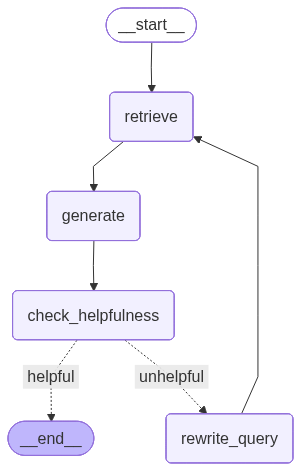

In [9]:
from IPython.display import Image, display

display(Image(meeting_agent.get_graph().draw_mermaid_png()))

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

# --- LLM 모델 정의 ---
# gpt-4o-mini 모델을 사용하겠습니다. 더 좋은 성능을 원하시면 gpt-4o 등으로 변경 가능합니다.
llm = ChatOpenAI(model="gpt-4o-mini")

# --- 1. 답변 생성(Generate) 노드 로직 ---

# 답변 생성을 위한 프롬프트 템플릿
generate_prompt = ChatPromptTemplate.from_template(
    """당신은 MOIT 플랫폼의 친절한 모임 추천 AI입니다.
    사용자에게 모임을 추천할 때는 반드시 아래 [검색된 정보]를 기반으로, 어떤 모임인지 명확하게 설명해주세요.

    [검색된 정보]:
    {context}

    [사용자 질문]:
    {query}
    """
)

# 답변을 문자열(String) 형태로 받기 위한 체인
generate_chain = generate_prompt | llm | StrOutputParser()

# 기존 generate 함수를 실제 LLM을 호출하도록 수정
def generate(state: AgentState):
    """검색된 정보를 바탕으로 답변을 생성합니다."""
    print("--- 2. GENERATE (LLM 호출) ---")
    
    query = state['query']
    context_docs = state['context']
    # Document 객체의 page_content만 추출하여 문자열로 합칩니다.
    context = "\n\n".join(doc.page_content for doc in context_docs)

    answer = generate_chain.invoke({
        "context": context,
        "query": query
    })
    
    print("생성된 답변:", answer)
    return {"answer": answer}


# --- 2. 유용성 검증(Check Helpfulness) 노드 로직 ---

# 답변이 유용한지 판단하기 위한 프롬프트 템플릿
check_helpfulness_prompt = ChatPromptTemplate.from_template(
    """당신은 AI 답변을 평가하는 엄격한 평가관입니다.
    주어진 [AI 답변]이 사용자의 [원본 질문]에 대해 정말로 유용하고 직접적인 답변을 하는지 평가해주세요.

    'helpful' 또는 'unhelpful' 둘 중 하나로만 답변해야 합니다.

    [원본 질문]: {query}
    [AI 답변]: {answer}
    """
)

# 답변을 'helpful' 또는 'unhelpful' 문자열로 받기 위한 체인
check_helpfulness_chain = check_helpfulness_prompt | llm | StrOutputParser()

# 기존 check_helpfulness 함수를 실제 LLM이 판단하도록 수정
def check_helpfulness(state: AgentState):
    """답변이 사용자에게 도움이 되는지 검증합니다."""
    print("--- 3. CHECK HELPFULNESS (LLM 호출) ---")
    
    query = state['query']
    answer = state['answer']
    
    result = check_helpfulness_chain.invoke({
        "query": query,
        "answer": answer
    })
    
    print("판단 결과:", result)
    # 결과를 사전 형태로 반환하도록 수정!
    if 'helpful' in result.lower():
        print("DECISION: helpful")
        return {"decision": "helpful"} # <-- 정상! 사전 형태로 보고서 제출
    else:
        print("DECISION: unhelpful")
        return {"decision": "unhelpful"} # <-- 정상! 사전 형태로 보고서 제출


# --- 3. 질문 재작성(Rewrite Query) 노드 로직 ---

# 질문을 다시 쓰기 위한 프롬프트 템플릿
rewrite_query_prompt = ChatPromptTemplate.from_template(
    """당신은 사용자의 질문을 더 좋은 검색 결과가 나올 수 있도록 명확하게 다듬는 프롬프트 엔지니어입니다.
    주어진 [원본 질문]을 바탕으로, 벡터 데이터베이스에서 더 관련성 높은 모임 정보를 찾을 수 있는 새로운 검색 질문을 하나만 만들어주세요.
    
    결과는 오직 새로운 검색 질문 텍스트만 포함해야 합니다.

    [원본 질문]: {query}
    """
)

# 새로운 질문을 문자열로 받기 위한 체인
rewrite_query_chain = rewrite_query_prompt | llm | StrOutputParser()

# 기존 rewrite_query 함수를 실제 LLM이 재작성하도록 수정
def rewrite_query(state: AgentState):
    """검색 결과가 별로일 때, 질문을 더 좋게 다시 작성합니다."""
    print("--- 4. REWRITE QUERY (LLM 호출) ---")
    
    query = state['query']
    
    new_query = rewrite_query_chain.invoke({"query": query})
    count = state.get('rewrite_count', 0) + 1
    
    print("새롭게 작성된 질문:", new_query)
    return {"query": new_query, "rewrite_count": count}


print("모든 노드 함수가 실제 LLM 로직으로 업데이트되었습니다!")

모든 노드 함수가 실제 LLM 로직으로 업데이트되었습니다!


In [11]:
# --- [1-6] 에이전트 실행 및 테스트 ---

# 에이전트에게 던질 질문
query = "강남역 근처에서 코딩 스터디 할 곳 찾아줘"

# 에이전트의 초기 상태를 설정합니다.
# rewrite_count는 0으로 시작합니다.
initial_state = {"query": query, "rewrite_count": 0}

# .stream()을 사용해 에이전트의 모든 작동 과정을 실시간으로 확인합니다.
for event in meeting_agent.stream(initial_state):
    # event 딕셔너리의 키(key)가 노드 이름입니다.
    node_name = list(event.keys())[0]
    # 해당 노드에서 나온 결과값(value)을 출력합니다.
    node_output = event[node_name]
    
    print(f"--- Event: '{node_name}' 노드 실행 ---")
    print(node_output)
    print("\n" + "="*30 + "\n")

--- 1. RETRIEVE (from existing Pinecone index) ---
검색된 정보: ['[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.', '[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.']
--- Event: 'retrieve' 노드 실행 ---
{'context': [Document(id='2d1223cd-cde8-4a11-bf03-2c27035d9747', metadata={'day': '토', 'location': '강남'}, page_content='[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.'), Document(id='e697e43b-c499-4556-b61e-10550c17b9c5', metadata={'day': '토', 'location': '강남'}, page_content='[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.')]}


--- 2. GENERATE ---
--- Event: 'generate' 노드 실행 ---
{'answer': '임시 답변: 기존 Pinecone 인덱스에서 검색된 정보를 바탕으로 모임을 추천합니다.'}


--- 3. CHECK HELPFULNESS (LLM 호출) ---
판단 결과: unhelpful
DECISION: helpful
--- Event: 'check_helpfulness' 노드 실행 ---
{'decision': 'helpful'}


